In [1]:
import torch 
import pandas as pd 
import torch.nn as nn 
from torch.utils.data import random_split, DataLoader, TensorDataset 
import torch.nn.functional as F 
import numpy as np 
import torch.optim as optim 
from torch.optim import AdamW
import random
import matplotlib.pyplot as plt
import seaborn as sns

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


In [2]:
def FizzBuzz(a):
    if a%15==0:
        return [1,0,0,0]
    elif a%5==0:
        return [0,1,0,0]
    elif a%3==0:
        return [0,0,1,0]
    else:
        return [0,0,0,1]

In [3]:
input_size = 16

def binary_encode(x):
    l = []
    for i in range(input_size):
        l.append(x%2)
        x=x//2
        
    return l[::-1]

In [4]:
binary_encode(2)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

In [5]:
xs = [binary_encode(n) for n in range(100,4000)]
xs1 = [binary_encode(n) for n in range(1,100)]


In [6]:
ys = [FizzBuzz(n) for n in range(100,4000)]
ys1 = [FizzBuzz(n) for n in range(1,100)]


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(xs, ys, test_size=0.8, random_state=42)

X_test = xs1
y_test = ys1

In [8]:

X_train = torch.Tensor(X_train) 
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

train_set = TensorDataset(X_train, y_train) 
validate_set = TensorDataset(X_val, y_val) 
test_set = TensorDataset(X_test, y_test) 
test_set2 = TensorDataset(X_train, y_train) 
test_set3 = TensorDataset(X_val, y_val) 


# Create Dataloader to read the data within batch sizes and put into memory. 
train_loader = DataLoader(train_set, batch_size = 400, shuffle = True) 
validate_loader = DataLoader(validate_set, batch_size = 400) 
test_loader = DataLoader(test_set, batch_size = 100)
test_loader2 = DataLoader(test_set2, batch_size = 100)
test_loader3 = DataLoader(test_set3, batch_size = 100)

In [9]:
# Define model parameters 


# Define neural network 
class Network(nn.Module): 
    def __init__(self, input_size, output_size, init_form="normal"): 
        super().__init__() 
        self.conv_stack = nn.Sequential(
        nn.Linear(input_size, 200), 
        nn.Tanh(),
        nn.Linear(200, 200), 
        nn.Tanh(),
        nn.Linear(200, 200),
        nn.Tanh(),
        nn.Linear(200, output_size))
        
                

        self.init_form = init_form
        if self.init_form is not None:
            self.init()

    def forward(self, x): 
        s = self.conv_stack(x)
        return s
    
    
        # xavier weight initialization
    def init(self):
        sigmoid_gain = torch.nn.init.calculate_gain("tanh")
        for child in self.conv_stack.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.xavier_normal_(child.weight,
                                                 gain=sigmoid_gain)
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.xavier_uniform_(child.weight,
                                                  gain=sigmoid_gain)
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()
    
  

    def __init__(self, input_size, output_size, init_form="normal"): 
        super().__init__() 
        self.conv_stack = nn.Sequential(
        nn.Linear(input_size, 100), 
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.Linear(100, output_size))

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_epoch(model,
                optimizer,
                criterion,
                train_loader):
    loss_history = []
    for batch in train_loader: 
        optimizer.zero_grad()
        x_train, y_train = batch # parse data
        x_train, y_train = x_train.to(device), y_train.to(device) # compute on gpu
        y_pred = model(x_train) # get predictions
        loss = criterion(y_pred,y_train) # compute loss
        loss_history.append(loss.cpu().detach().numpy()) # write loss to log
        loss.backward()
        optimizer.step()
    return loss_history

In [11]:
def validate(model,
             criterion,
             val_loader):
    cumloss = 0
    loss_history = []
    with torch.no_grad():
        for batch in val_loader:
            x_train, y_train = batch # parse data
            x_train, y_train = x_train.to(device), y_train.to(device) # compute on gpu
            y_pred = model(x_train) # get predictions
            loss = criterion(y_pred,y_train) # compute loss
            loss_history.append(loss.cpu().detach().numpy()) # write loss to log
            cumloss += loss
    return cumloss / len(val_loader), loss_history # mean loss and history

In [12]:
def gini(model):
    a1 = torch.abs(torch.flatten((model.conv_stack[0].weight))) 
    a2 =  torch.abs(torch.flatten((model.conv_stack[2].weight)))
    a3 = torch.abs(torch.flatten((model.conv_stack[4].weight)))
    a4 = torch.abs(torch.flatten((model.conv_stack[6].weight)))
    n1 = len(a1)
    n2 = len(a2)
    n3 = len(a3)
    n4 = len(a4)
    a_sort1, ind = torch.sort(a1)
    a_sort2, ind = torch.sort(a2)
    a_sort3, ind = torch.sort(a3)
    a_sort4, ind = torch.sort(a4)
    x_m1 = torch.mean(a1)
    x_m2 = torch.mean(a2)
    x_m3 = torch.mean(a3)
    x_m4 = torch.mean(a4)
    S = 0


    for i in range(n1):
        S += i*(a_sort1[i]-x_m1) 
    
    gini1 = 2*S/x_m1/n1**2
    S = 0
    
    for i in range(n2):
        S += i*(a_sort2[i]-x_m2) 
    
        
    gini2 = 2*S/x_m2/n2**2
    S = 0
    
    for i in range(n3):
        S += i*(a_sort3[i]-x_m3) 
        
    gini3 = 2*S/x_m3/n3**2
    S = 0
    
    for i in range(n4):
        S += i*(a_sort4[i]-x_m4) 
        
    gini4 = 2*S/x_m4/n4**2


    
    return gini1.detach().cpu().numpy(), gini2.detach().cpu().numpy(), gini3.detach().cpu().numpy(), gini4.detach().cpu().numpy()
    

In [13]:
def test(model, test_loader):
    cumloss1 = 0
    with torch.no_grad():
        for batch in test_loader:
            x_train, y_train = batch # parse data
            x_train, y_train = x_train.to(device), y_train.to(device) # compute on gpu
            y_pred = model(x_train) # get predictions
            loss1 = torch.sum(torch.argmax(y_pred,dim=1)==torch.argmax(y_train,dim=1)) # compute loss
            cumloss1 += loss1/len(batch[0])
    return (cumloss1 / len(test_loader)).cpu().detach().numpy() 


In [14]:
from tqdm import tqdm

def train_model(model, optimizer, model_name=None, n_epochs=5):
  
    criterion = nn.CrossEntropyLoss().to(device)

    train_history = {}
    train_history['model_name'] = model_name
    train_history['loss_on_train'] = []
    train_history['loss_on_val'] = []
    train_history['gini1'] = []
    train_history['gini2'] = []
    train_history['gini3'] = []
    train_history['gini4'] = []
    train_history['test'] = []
    train_history['test2'] = []
    train_history['test3'] = []

    for epoch in tqdm(range(n_epochs)):
        loss_on_train = train_epoch(model,
                                    optimizer,
                                    criterion,
                                    train_loader)
        _, loss_on_test = validate(model,
                                   criterion,
                                   validate_loader)
        train_history['loss_on_train'].append(np.mean(loss_on_train))
        train_history['loss_on_val'].append(np.mean(loss_on_test))
        
        if epoch%100 == 0:
            model.eval()
            arr = gini(model)
            train_history['gini1'].append(arr[0])
            train_history['gini2'].append(arr[1])
            train_history['gini3'].append(arr[2])
            train_history['gini4'].append(arr[3])
            model.train()
        
        model.eval()
        train_history['test'].append(test(model, test_loader))
        train_history['test2'].append(test(model, test_loader2))
        train_history['test3'].append(test(model, test_loader3))
        model.train()
        
        
        scheduler.step()
    return train_history

In [15]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


set_random_seed(42)

model = Network(input_size,4).to(device) 
optimizer = optim.AdamW(model.parameters(), weight_decay=0.2, betas=(0.9,0.95), lr=0.001)

lambda1 = lambda epoch: 1.0 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1, last_epoch = -1)

n_epochs = 50000
history = train_model(model, optimizer, model_name='model', n_epochs=n_epochs)


100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [1:49:48<00:00,  7.59it/s]


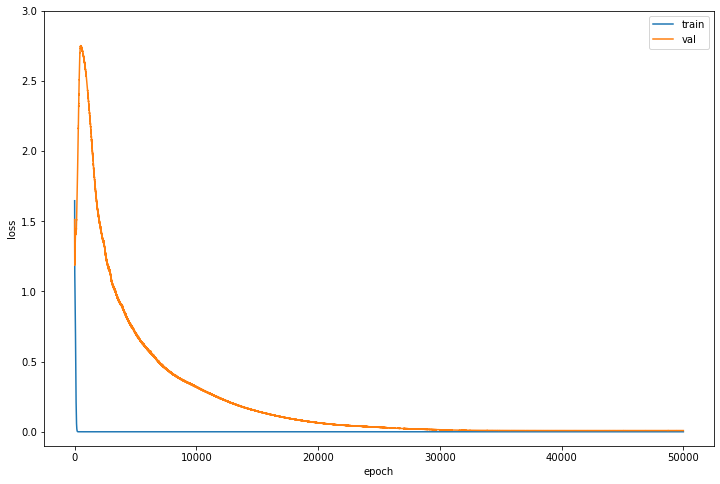

In [18]:
limit_range = (-0.1,3)
plt.figure(figsize=(12, 8))
plt.ylim(limit_range)
plt.plot(range(1,n_epochs+1), (history['loss_on_train']), label='train')
plt.plot(range(1,n_epochs+1), (history['loss_on_val']), label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()


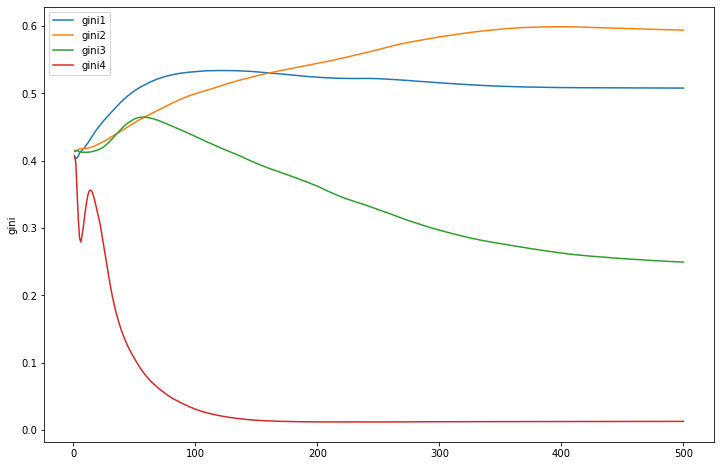

In [19]:
plt.figure(figsize=(12, 8))
plt.plot(range(1,n_epochs//100+1), (history['gini1']), label='gini1')
plt.plot(range(1,n_epochs//100+1), (history['gini2']), label='gini2')
plt.plot(range(1,n_epochs//100+1), (history['gini3']), label='gini3')
plt.plot(range(1,n_epochs//100+1), (history['gini4']), label='gini4')
plt.ylabel('gini')
plt.legend()

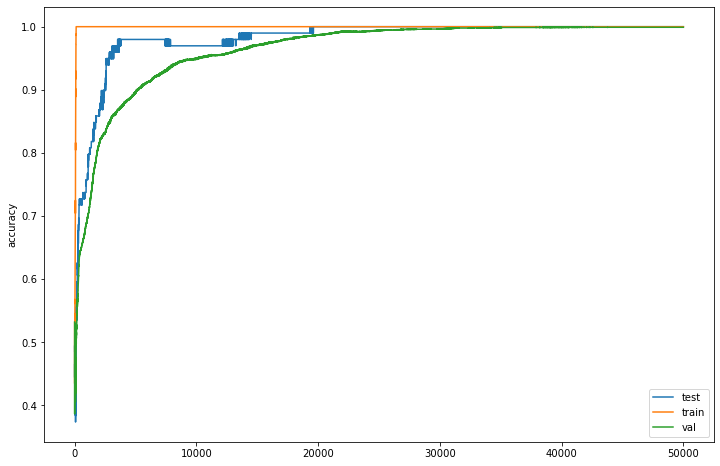

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(range(1,n_epochs+1), (history['test']), label='test')
plt.plot(range(1,n_epochs+1), (history['test2']), label='train')
plt.plot(range(1,n_epochs+1), (history['test3']), label='val')
plt.ylabel('accuracy')
plt.legend()

In [21]:
model.eval()

Network(
  (conv_stack): Sequential(
    (0): Linear(in_features=16, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=200, out_features=4, bias=True)
  )
)

In [22]:
weight_sum = (((model.conv_stack[0].weight)*(model.conv_stack[0].weight)).sum()  
+ ((model.conv_stack[2].weight)*(model.conv_stack[2].weight)).sum()
+ ((model.conv_stack[4].weight)*(model.conv_stack[4].weight)).sum() 
+ ((model.conv_stack[6].weight)*(model.conv_stack[6].weight)).sum())

weight_sum

tensor(2892.6987, device='cuda:0', grad_fn=<AddBackward0>)

In [24]:
def decode_fizzbuzz(x):
    if x==0:
        return 'FizzBuzz'
    elif x==1:
        return 'Fizz'
    elif x==2:
        return 'Buzz'
    else:
        return 'None'

In [25]:
X1 = binary_encode(6)




input1 = torch.Tensor(X1) 
a1 = (model(input1.to(device))).cpu().detach().numpy()
decode_fizzbuzz(np.argmax(a1))

'Buzz'